In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from collections import deque

import time
import math

import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_excel("test.xlsx")
df

,TEA,InjectorDuty,T13,DPs1_13,DT13_t,T2,Ps3,DT2_t,PRs3_0,Ps38,...,a1_y_w9x1,a1_y_w9x1_tfa_delta,a1_y_w9x1_tfa_variance,a1_z_100Hz,a1_z_100Hz_tfa_delta,a1_z_100Hz_tfa_variance,a1_z_w9x1,a1_z_w9x1_tfa_delta,a1_z_w9x1_tfa_variance,a1_T
0,313.149994,0.379451,300.048431,-622.1,-0.001432,315.970306,19453.998997,-0.022526,0.191996,59435.548556,...,0.634733,0.000000,0.009574,0.017786,0.000000,0.000098,0.286584,0.000000,0.002601,331.966425
1,313.149994,0.379696,300.048431,-622.1,-0.001432,315.993744,19453.998997,-0.019271,0.191996,59712.501538,...,0.446491,0.000000,0.009449,0.019293,0.000000,0.000097,0.191387,0.000000,0.002601,331.966425
2,313.149994,0.380234,300.024994,-622.1,-0.002214,315.993744,19769.620732,-0.019271,0.195111,59422.957075,...,0.428736,0.000000,0.009454,0.043535,0.000000,0.000098,0.187689,0.000000,0.002611,331.966425
3,313.149994,0.379855,300.024994,-622.1,-0.002344,316.017181,19717.017110,-0.018490,0.194592,59611.792040,...,0.636060,0.000000,0.009577,0.025968,0.000000,0.000097,0.280307,0.000000,0.002614,331.966425
4,313.149994,0.379642,300.064056,-622.1,-0.001693,316.017181,20190.449713,-0.022396,0.199264,59574.025047,...,0.505796,0.000000,0.009503,0.030051,0.000000,0.000096,0.221400,0.000000,0.002615,331.966425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3476,309.149994,0.459188,298.978119,-622.1,-0.008073,316.337494,20677.033708,0.005339,0.204066,59422.957075,...,7.960145,36.026524,0.889974,0.110364,0.614012,0.020977,2.341758,18.676417,0.142202,335.831159
3477,309.149994,0.463592,298.946869,-622.1,-0.008594,316.337494,21005.806349,0.004948,0.207311,59397.781563,...,6.598782,37.043301,0.904729,0.068953,0.628046,0.021025,2.264824,19.067803,0.142142,335.831159
3478,309.149994,0.469627,298.946869,-622.1,-0.008594,316.110931,20913.750009,0.000000,0.206403,59397.781563,...,6.338685,38.070609,0.912701,3.779113,0.676541,0.083161,2.182078,19.457799,0.140931,335.831159
3479,309.149994,0.482590,298.962494,-622.1,-0.007943,316.110931,20532.373746,0.000000,0.202639,59460.724068,...,6.513544,39.123900,0.919338,3.289868,0.753399,0.128844,1.828923,19.848553,0.140293,335.831159


In [17]:
# Step 1: Read all data from the Excel file
def get_data(file_path):
    data = pd.read_excel(file_path)
    print(f"Data loaded: {data.shape[0]} rows, {data.shape[1]} columns.")
    return data

# Step 2: Data preprocessing
def preprocess_data(data, data_columns, scaler=None):
    existing_columns = [col for col in data_columns if col in data.columns]
    if not existing_columns:
        raise ValueError("None of the specified columns were found in the dataset.")
    
    sensor_data = data[existing_columns]
    sensor_data = sensor_data.dropna()

    if scaler is None:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(sensor_data)
    else:
        scaled_data = scaler.transform(sensor_data)
    return scaled_data, scaler

# Step 3: Compute centroid
def compute_centroid(scaled_data):
    return np.mean(scaled_data, axis=0)

# Step 4: Real-time monitoring with moving window, dynamic centroid, and periodic updates
def real_time_monitoring(all_data, data_columns, window_size, consecutive_anomalies, x_samples):
    window = deque(maxlen=window_size)
    results = []
    scaler = None
    centroid = None
    threshold = None
    anomaly_counter = 0
    computation_times = []
    centroid_history = []  # Store centroid evolution
    current_sample = 0

    print("Filling initial window...")
    for index in range(window_size):
        new_data_df = all_data.iloc[index]
        new_data_df = new_data_df.to_frame().T
        window.append(new_data_df.iloc[0])

    print("Computing centroid for the initial window...")
    window_df = pd.DataFrame(window)
    start_time = time.time()
    scaled_window_data, scaler = preprocess_data(window_df, data_columns)
    centroid = compute_centroid(scaled_window_data)
    centroid_history.append(centroid)

    window_distances = np.linalg.norm(scaled_window_data - centroid, axis=1)
    threshold = 1.3 * (np.percentile(window_distances, 99))
    end_time = time.time()
    print(f"Distance threshold set to: {threshold:.6f}")
    print("Processing and centroid computation time:", end_time - start_time, "seconds")

    print("Starting real-time monitoring...")
    for index in range(window_size, len(all_data)):
        start_time = time.time()
        next_data_df = all_data.iloc[index]
        next_data_df = next_data_df.to_frame().T
        scaled_next_data, _ = preprocess_data(next_data_df, data_columns, scaler)
        distance = np.linalg.norm(scaled_next_data - centroid, axis=1)[0]
        end_time = time.time()
        computation_times.append(end_time - start_time)

        if 'timestamp' in next_data_df.columns:
            timestamp = next_data_df['timestamp'].values[0]
        else:
            timestamp = index

        if distance > threshold:
            anomaly_counter += 1
            print(f"Anomaly detected at timestamp {timestamp} - Distance: {distance:.6f} (Anomaly counter: {anomaly_counter})")
        else:
            anomaly_counter = 0
            print(f"Normal data at timestamp {timestamp} - Distance: {distance:.6f}")

        if anomaly_counter >= consecutive_anomalies:
            print(f"********** CONFIRMED ANOMALY at timestamp {timestamp} after {consecutive_anomalies} consecutive detections ********")
            anomaly = True
            anomaly_counter = 0
        else:
            anomaly = False

        results.append({
            'timestamp': timestamp,
            'distance': distance,
            'anomaly': anomaly
        })

        window.append(next_data_df.iloc[0])
        current_sample += 1

        if current_sample % x_samples == 0:
            window_df = pd.DataFrame(window)
            # scaler = None  # Resetting scaler was tested, but distances drop to 0 after update.
            scaled_window_data, _ = preprocess_data(window_df, data_columns, scaler)
            centroid = compute_centroid(scaled_window_data)
            centroid_history.append(centroid)
            
            window_distances = np.linalg.norm(scaled_window_data - centroid, axis=1)
            threshold = 1.3 * (np.percentile(window_distances, 99))
            print(f"------Distance threshold updated to: {threshold:.6f}---------")

    return results, computation_times, threshold, centroid_history


# Main program
if __name__ == "__main__":
    data_path = 'test.xlsx'

    data_columns = [
        'w9',
        'T4',
        'ACC_1_x_100Hz',
        'ACC_1_y_100Hz',
        'ACC_1_z_100Hz',
        'ACC_1_x_w9x1',
        'ACC_1_y_w9x1',
        'ACC_1_z_w9x1',
        'InjectorDuty'
    ]

    window_size = 1200
    consecutive_anomalies = 10
    x_samples = 100

    all_data = get_data(data_path)
    results, computation_times, threshold, centroid_history = real_time_monitoring(
        all_data, data_columns, window_size, consecutive_anomalies, x_samples
    )

    results_df = pd.DataFrame(results)
    results_df['computation_time'] = computation_times

Data loaded: 3481 rows, 37 columns.
Filling initial window...
Computing centroid for the initial window...
Distance threshold set to: 3.616123
Processing and centroid computation time: 0.003513813018798828 seconds
Starting real-time monitoring...
Normal data at timestamp 1200 - Distance: 2.441307
Normal data at timestamp 1201 - Distance: 2.340950
Normal data at timestamp 1202 - Distance: 2.290713
Normal data at timestamp 1203 - Distance: 2.185516
Normal data at timestamp 1204 - Distance: 2.060018
Normal data at timestamp 1205 - Distance: 2.064441
Normal data at timestamp 1206 - Distance: 1.879052
Normal data at timestamp 1207 - Distance: 2.194536
Normal data at timestamp 1208 - Distance: 2.396183
Normal data at timestamp 1209 - Distance: 2.211729
Normal data at timestamp 1210 - Distance: 1.784410
Normal data at timestamp 1211 - Distance: 1.796703
Normal data at timestamp 1212 - Distance: 2.203201
Normal data at timestamp 1213 - Distance: 2.019534
Normal data at timestamp 1214 - Distanc

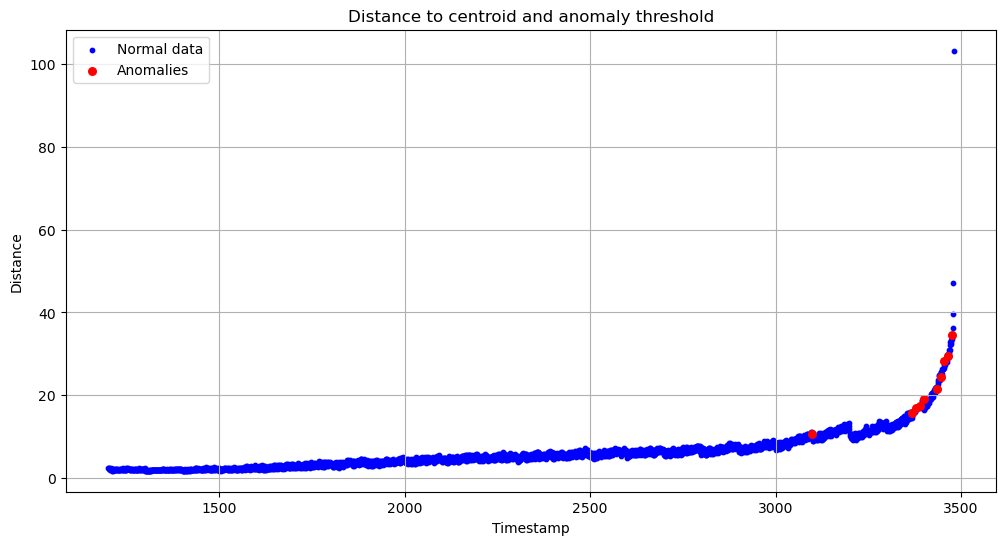

In [18]:
# Separate normal points and anomalies
normal_points = results_df[results_df['anomaly'] == False]
anomalous_points = results_df[results_df['anomaly'] == True]

plt.figure(figsize=(12, 6))

# Plot normal points in blue
plt.scatter(normal_points['timestamp'], normal_points['distance'], color='blue', label='Normal data', s=10)

# Plot anomalies in red
plt.scatter(anomalous_points['timestamp'], anomalous_points['distance'], color='red', label='Anomalies', s=30)


plt.xlabel('Timestamp')
plt.ylabel('Distance')
plt.title('Distance to centroid and anomaly threshold')
plt.legend()
plt.grid(True)
plt.show()